In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore

In [2]:
# Read the pickle file using read_pickle
df_stores = pd.read_pickle('business.pkl')

In [3]:
# Assuming your DataFrame is named 'df'
df_stores = df_stores.iloc[:, :14]  # Select the first 15 columns using iloc

# Filtering the States of interest
states = ['NV','TX','CA','FL','NY']

df_stores = df_stores[df_stores['state'].isin(states)]

df_stores.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
10,UJsufbvfyfONHeWdvAHKjA,Marshalls,21705 Village Lakes Sc Dr,Land O' Lakes,FL,34639,28.190459,-82.45738,3.5,6,1,"{'RestaurantsPriceRange2': '2', 'BikeParking':...","Department Stores, Shopping, Fashion","{'Monday': '9:30-21:30', 'Tuesday': '9:30-21:3..."
13,jaxMSoInw8Poo3XeMJt8lQ,Adams Dental,15 N Missouri Ave,Clearwater,FL,33755,27.966235,-82.787412,5.0,10,1,{'ByAppointmentOnly': 'True'},"General Dentistry, Dentists, Health & Medical,...","{'Monday': '7:30-15:30', 'Tuesday': '7:30-15:3..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
16,rBmpy_Y1UbBx8ggHlyb7hA,Arizona Truck Outfitters,625 N Stone Ave,Tucson,FL,85705,32.229872,-110.972342,4.5,10,1,"{'DriveThru': 'False', 'BusinessAcceptsCreditC...","Automotive, Auto Parts & Supplies, Auto Custom...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:0', '..."


In [4]:
# Define the list of gastronomic tags to filter on
gastronomic_tags = ['food', 'restaurant', 'cafe', 'bar', 'Restaurant', 'Bar','Food']  # replace with your actual list of tags


# Use a nested loop to check if any of the gastronomic tags are in the category list for each row
is_gastronomic = []

df_stores = df_stores.dropna(subset=['categories'])
df_stores['categories'] = df_stores['categories'].apply(lambda x: x.replace(', ', ',').split(','))


for categories in df_stores['categories']:
    found_tag = False
    for tag in categories:
        if tag.lower() in gastronomic_tags:
            found_tag = True
            break
    is_gastronomic.append(found_tag)

# Filter the DataFrame based on this condition
df_stores_food = df_stores[is_gastronomic]

In [6]:
df_stores_food.drop_duplicates

<bound method DataFrame.drop_duplicates of                    business_id                   name   
3       MTSW4McQd7CbVtyjqoe9mw     St Honore Pastries  \
14      0bPLkL0QhhPO5kt1_EXmNQ   Zio's Italian Market   
53      cVBxfMC4lp3DnocjYA3FHQ      Paws The Cat Cafe   
82      ppFCk9aQkM338Rgwpl2F5A                   Wawa   
88      LhpPSrulqVeTyJeK2xydvQ  Fresh Fruits & Salads   
...                        ...                    ...   
150247  uakBDIQ5uDIG9QsVSv3aHA          King of Tarts   
150283  Y5gyxnQt44B3axgzrjttlw     Don Cruz Snowballs   
150293  0UqeZTDBdV0uY3wesbLvYQ                   ampm   
150306  wVxXRFf10zTTAs11nr4xeA           PrimoHoagies   
150321  AM7O0cwkxm6w_e0Q7-f9FQ              Starbucks   

                          address          city state postal_code   latitude   
3                     935 Race St  Philadelphia    CA       19107  39.955505  \
14                  2575 E Bay Dr         Largo    FL       33771  27.916116   
53               10588 109 Stree

In [7]:
# Now get the reviews

df_reviews = pd.read_csv('reviews_GoogleYelp_text_tokens.csv')
df_reviews.head()

C:\Users\Marco\AppData\Local\Temp\ipykernel_14900\14484762.py:3: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews = pd.read_csv('reviews_GoogleYelp_text_tokens.csv')


,review_id,tokens,text,rating,user_id,gmap_id,time
0,Xs8Z8lmKkosqW5mw_sVAoA,"['absolute', 'favorite', 'cafe', 'city', 'blac...",My absolute favorite cafe in the city. Their b...,5,NaN,NaN,NaN
1,yCbzm_d4cHpfUX00Ljvgmg,"['start', 'artichoke', 'dip', 'big', 'mistake'...","We started with the artichoke dip, big mistake...",2,NaN,NaN,NaN
2,4KpIldEM-tdnrJLqYzRfZQ,"['cannolis', 'awesome', 'fill', 'order', 'fill...",I've only had the cannolis here but they are a...,5,NaN,NaN,NaN
3,r1tPwFMILy0COeEQ-B3YLw,"['pleasure', 'meet', 'ann', 'today', 'helpful'...",I had the pleasure to meet with Ann today and ...,5,NaN,NaN,NaN
4,9IG9eB3K-RdIonPBuZ0psw,"['busy', 'chick', 'fil', 'see', 'manage', 'qui...",This is one of the busiest Chick fil A's I've ...,5,NaN,NaN,NaN


In [8]:
'''
Primero tengo que recuperar para cada row en df_stores las reviews_id asociadas

2. Con esas reviews, filtro el df_reviews

3. Para cada review obtengo la probabilidad por topico a 2 decimales

4. Para cada topico hago binary

5. Luego saco el avg de cada topico

6. Asigno esa distribucion al local.

SyntaxError: unterminated triple-quoted string literal (detected at line 2) (1507508638.py, line 1)

In [9]:
file_path = './review_yelp.json'
# Specify the number of rows to read per batch (e.g., 250000 rows)
batch_size = 250000

# Create an empty list to store the loaded DataFrames
dfs = []

# Read the JSON file in batches using read_json with chunksize
for chunk in pd.read_json(file_path, lines=True, chunksize=batch_size):
    dfs.append(chunk)

# Concatenate the list of DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

In [13]:
df_stores_food2 = df_stores_food.iloc[0:2]

df_stores_food2.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","[Restaurants, Food, Bubble Tea, Coffee & Tea, ...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","[Food, Delis, Italian, Bakeries, Restaurants]","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."


In [ ]:
# Load and Check the model
lda_model_loaded = LdaMulticore.load('./LDA_model/lda_model_10topics')
dictionary = Dictionary.load('./GensimDictionary/dictionary.dict')

df_reviews['tokens'] = df_reviews['tokens'].apply(ast.literal_eval)


In [69]:
data_list = []
# Iterate through each row in df
for index, row in df_stores_food.iterrows():
    # Create an empty list to store the review_id values
    review_ids = []


    business_id = row['business_id']
    
    # Find all rows in df2 with the same business_id
    matching_rows = df[df['business_id'] == business_id]

    # Extract the values from the 'review_id' column and append them to the list
    review_ids.extend(matching_rows['review_id'].tolist())

    # Filter the rows in df_reviews using the review_ids list
    filtered_reviews = df_reviews[df_reviews['review_id'].isin(review_ids)]


    # Create a dictionary to store the values
    data_dict = {}
    for column_name in range(10):
        data_dict[str(column_name)] = []

    for index2, row2 in filtered_reviews.iterrows():
        # Predict
        new_doc_bow = dictionary.doc2bow(row2['tokens'])
        topics_probabilities = lda_model_loaded.get_document_topics(new_doc_bow)

        
        # Create a dictionary to store the probabilities for each topic
        topic_dict = dict(topics_probabilities)

        # Append the values to the corresponding column in data_dict
        for column_name in data_dict.keys():
            value = topic_dict.get(int(column_name), 0)
            
            # Apply the rule
            if value < 0.1:
                value = 0
            elif value > 0.1:
                value = 1

            value = value * row2['rating']
            data_dict[column_name].append(value)

    # Create the DataFrame
    df_aux = pd.DataFrame(data_dict)

    # Calculate the average of each column in the DataFrame (excluding 0 values)
    avg_values = df_aux[df_aux != 0].mean()
    avg_values['business_id'] = business_id
    data_list.append(avg_values)


# Create the DataFrame
df_avg_values = pd.DataFrame(data_list)


df_avg_values.head()    

,0,1,2,3,4,5,6,7,8,9,business_id
0,4.500000,4.388889,4.273973,4.000000,3.593750,4.095238,4.266667,4.038462,4.500,4.533333,MTSW4McQd7CbVtyjqoe9mw
1,4.666667,4.787879,4.812500,4.471429,4.062500,4.388889,4.446809,4.480519,NaN,4.735294,0bPLkL0QhhPO5kt1_EXmNQ
2,4.923077,4.941176,5.000000,NaN,4.833333,5.000000,NaN,4.937500,5.000,5.000000,cVBxfMC4lp3DnocjYA3FHQ
3,3.250000,3.375000,3.384615,3.400000,2.909091,3.700000,2.600000,3.380952,3.625,3.900000,ppFCk9aQkM338Rgwpl2F5A
4,5.000000,NaN,4.285714,4.166667,4.000000,NaN,5.000000,4.666667,NaN,5.000000,LhpPSrulqVeTyJeK2xydvQ


In [70]:
df_avg_values.to_csv('avg_yelp.csv', index=False)

In [ ]:
'''
Para Google es similar

Para cada local, uso el gmap id para recuperar todas las reviews

Obtengo para cada review la probabilidad por topico

Umbralo

Multiplico por rating

Promedio

Asigno al local.

''' 

In [77]:
df_reviews.head()

,review_id,tokens,text,rating,user_id,gmap_id,time
0,Xs8Z8lmKkosqW5mw_sVAoA,"[absolute, favorite, cafe, city, black, white,...",My absolute favorite cafe in the city. Their b...,5,NaN,NaN,NaN
1,yCbzm_d4cHpfUX00Ljvgmg,"[start, artichoke, dip, big, mistake, cold, ch...","We started with the artichoke dip, big mistake...",2,NaN,NaN,NaN
2,4KpIldEM-tdnrJLqYzRfZQ,"[cannolis, awesome, fill, order, filling, phen...",I've only had the cannolis here but they are a...,5,NaN,NaN,NaN
3,r1tPwFMILy0COeEQ-B3YLw,"[pleasure, meet, ann, today, helpful, positive...",I had the pleasure to meet with Ann today and ...,5,NaN,NaN,NaN
4,9IG9eB3K-RdIonPBuZ0psw,"[busy, chick, fil, see, manage, quick, excepti...",This is one of the busiest Chick fil A's I've ...,5,NaN,NaN,NaN


In [78]:
df_reviews_G = df_reviews.dropna(subset=['gmap_id'])

In [79]:
df_reviews_G.head()

,review_id,tokens,text,rating,user_id,gmap_id,time
474713,NaN,"[surprised, taco, bit, small, quality, worth, ...",Pleasantly surprised. Although the tacos were ...,5,1.171482e+20,0x80c8c10f727e3ae1:0x9085c8978a7b1813,1.629819e+12
474714,NaN,"[surprised, taco, bit, small, quality, worth, ...",Pleasantly surprised. Although the tacos were ...,5,1.171482e+20,0x80c8c10f727e3ae1:0x9085c8978a7b1813,1.629819e+12
474715,NaN,"[surprised, taco, bit, small, quality, worth, ...",Pleasantly surprised. Although the tacos were ...,5,1.171482e+20,0x80c8c10f727e3ae1:0x9085c8978a7b1813,1.629819e+12
474716,NaN,"[surprised, taco, bit, small, quality, worth, ...",Pleasantly surprised. Although the tacos were ...,5,1.171482e+20,0x80c8c10f727e3ae1:0x9085c8978a7b1813,1.629819e+12
474717,NaN,"[let, tell, awhiiiiiile, find, good, taco, pla...",Let me tell you. It has been awhiiiiiile since...,5,1.076706e+20,0x80c8c10f727e3ae1:0x9085c8978a7b1813,1.620677e+12


In [83]:
gmap_ids = df_reviews_G['gmap_id'].unique()

In [84]:
len(gmap_ids)

19523

In [85]:
data_list = []
# Iterate through each row in df
for id in gmap_ids:
    # Create an empty list to store the review_id values
    review_ids = []


    business_id = id
    
    # Find all rows in df2 with the same business_id
    filtered_reviews = df_reviews_G[df_reviews_G['gmap_id'] == id]


    # Create a dictionary to store the values
    data_dict = {}
    for column_name in range(10):
        data_dict[str(column_name)] = []

    for index2, row2 in filtered_reviews.iterrows():
        # Predict
        new_doc_bow = dictionary.doc2bow(row2['tokens'])
        topics_probabilities = lda_model_loaded.get_document_topics(new_doc_bow)

        
        # Create a dictionary to store the probabilities for each topic
        topic_dict = dict(topics_probabilities)

        # Append the values to the corresponding column in data_dict
        for column_name in data_dict.keys():
            value = topic_dict.get(int(column_name), 0)
            
            # Apply the rule
            if value < 0.1:
                value = 0
            elif value > 0.1:
                value = 1

            value = value * row2['rating']
            data_dict[column_name].append(value)

    # Create the DataFrame
    df_aux = pd.DataFrame(data_dict)

    # Calculate the average of each column in the DataFrame (excluding 0 values)
    avg_values = df_aux[df_aux != 0].mean()
    avg_values['business_id'] = business_id
    data_list.append(avg_values)


# Create the DataFrame
df_avg_values = pd.DataFrame(data_list)


df_avg_values.head()    

,0,1,2,3,4,5,6,7,8,9,business_id
0,5.0,NaN,NaN,5.0,5.0,5.000000,NaN,5.000000,NaN,5.000000,0x80c8c10f727e3ae1:0x9085c8978a7b1813
1,NaN,NaN,NaN,5.0,NaN,4.500000,NaN,3.333333,5.0,5.000000,0x80c8cf0fffffffff:0x4e446fa30178181b
2,NaN,4.666667,5.0,4.5,NaN,4.666667,5.0,4.500000,NaN,5.000000,0x80c8c1186114520b:0x181d6e75c4cd85ed
3,5.0,4.600000,5.0,NaN,4.0,5.000000,NaN,4.000000,NaN,4.333333,0x80c8e999c57b8a37:0xc2f84294a152ac91
4,2.0,NaN,NaN,5.0,3.0,4.666667,1.0,1.000000,3.5,3.500000,0x80c8c13a7218e783:0x5d00abbb6190baa5


In [86]:
df_avg_values.to_csv('avg_google.csv', index=False)

## Filtering by State

In [2]:
folder_path = './metadata-sitios/'
df_stores_google = pd.DataFrame()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        dfaux = pd.read_json(file_path, lines=True)
        df_stores_google = pd.concat([df_stores_google, dfaux], ignore_index=True)

In [3]:
# Define the list of gastronomic tags to filter on
gastronomic_tags = ['food', 'restaurant', 'cafe', 'bar', 'Restaurant', 'Bar','Food']  # replace with your actual list of tags

# As there are few shops without tags, they are going to be dropped
df_stores_google = df_stores_google.dropna(subset=['category'])

# Use a nested loop to check if any of the gastronomic tags are in the category list for each row
is_gastronomic = []
for categories in df_stores_google['category']:
    found_tag = False
    for tag in categories:
        if tag.lower() in gastronomic_tags:
            found_tag = True
            break
    is_gastronomic.append(found_tag)

# Filter the DataFrame based on this condition
df_gastronomic_google = df_stores_google[is_gastronomic]

In [5]:
states = ['California','Florida','Nevada','New_York','Texas']

for state in states:

    folder_path = f'./review-{state}/'
    dfmerge = pd.DataFrame()

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            dfaux = pd.read_json(file_path, lines=True)
            dfmerge = pd.concat([dfmerge, dfaux], ignore_index=True)

    gmap_ids = dfmerge['gmap_id'].unique()

    if state == 'California':
        df_california = df_gastronomic_google[df_gastronomic_google['gmap_id'].isin(gmap_ids)]
        df_california = df_california[['gmap_id','name','category']]

    if state == 'Florida':
        df_florida = df_gastronomic_google[df_gastronomic_google['gmap_id'].isin(gmap_ids)]
        df_florida = df_florida[['gmap_id','name','category']]
    
    if state == 'Nevada':
        df_nevada = df_gastronomic_google[df_gastronomic_google['gmap_id'].isin(gmap_ids)]
        df_nevada = df_nevada[['gmap_id','name','category']]
    
    if state == 'New_York':
        df_ny = df_gastronomic_google[df_gastronomic_google['gmap_id'].isin(gmap_ids)]
        df_ny = df_ny[['gmap_id','name','category']]
    
    if state == 'Texas':
        df_texas = df_gastronomic_google[df_gastronomic_google['gmap_id'].isin(gmap_ids)]
        df_texas = df_texas[['gmap_id','name','category']]
    

    

In [7]:
df_california = df_california.rename(columns={'gmap_id': 'business_id', 'category': 'categories'})
df_florida = df_florida.rename(columns={'gmap_id': 'business_id', 'category': 'categories'})
df_nevada = df_nevada.rename(columns={'gmap_id': 'business_id', 'category': 'categories'})
df_ny = df_ny.rename(columns={'gmap_id': 'business_id', 'category': 'categories'})
df_texas = df_texas.rename(columns={'gmap_id': 'business_id', 'category': 'categories'})

In [8]:
# Yelp Dataset
# Read the pickle file using read_pickle
df_stores = pd.read_pickle('business.pkl')
# Assuming your DataFrame is named 'df'
df_stores = df_stores.iloc[:, :14]  # Select the first 15 columns using iloc

# Filtering the States of interest
states = ['NV','TX','CA','FL','NY']

df_stores = df_stores[df_stores['state'].isin(states)]



In [9]:
# Define the list of gastronomic tags to filter on
gastronomic_tags = ['food', 'restaurant', 'cafe', 'bar', 'Restaurant', 'Bar','Food']  # replace with your actual list of tags


# Use a nested loop to check if any of the gastronomic tags are in the category list for each row
is_gastronomic = []

df_stores = df_stores.dropna(subset=['categories'])
df_stores['categories'] = df_stores['categories'].apply(lambda x: x.replace(', ', ',').split(','))


for categories in df_stores['categories']:
    found_tag = False
    for tag in categories:
        if tag.lower() in gastronomic_tags:
            found_tag = True
            break
    is_gastronomic.append(found_tag)

# Filter the DataFrame based on this condition
df_stores = df_stores[is_gastronomic]

In [13]:
# Filtering the States of interest
states = ['NV','TX','CA','FL','NY']

for state in states:
    dfaux = df_stores[df_stores['state'] == state]
    dfaux = dfaux[['business_id','name','categories']]

    
    if state == 'CA':
        df_california = pd.concat([df_california, dfaux], ignore_index=True)
        
    if state == 'FL':
        df_florida = pd.concat([df_florida, dfaux], ignore_index=True)

    if state == 'NV':
        df_nevada = pd.concat([df_nevada, dfaux], ignore_index=True)

    if state == 'NY':
        df_ny = pd.concat([df_ny, dfaux], ignore_index=True)

    if state == 'TX':
        df_texas = pd.concat([df_texas, dfaux], ignore_index=True)  

In [14]:
df_stores.head(-2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","[Restaurants, Food, Bubble Tea, Coffee & Tea, ...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","[Food, Delis, Italian, Bakeries, Restaurants]","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
53,cVBxfMC4lp3DnocjYA3FHQ,Paws The Cat Cafe,10588 109 Street,Edmonton,FL,T5H 3B2,53.549633,-113.50878,5.0,20,0,"{'RestaurantsAttire': ''casual'', 'Restaurants...","[Coffee & Tea, Cafes, Pets, Restaurants, Pet A...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-21:0', ..."
82,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,Philadelphia,FL,19104,39.954573,-75.194894,3.0,56,1,"{'Alcohol': 'u'none'', 'RestaurantsGoodForGrou...","[Restaurants, Automotive, Delis, Gas Stations,...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
88,LhpPSrulqVeTyJeK2xydvQ,Fresh Fruits & Salads,114 N 3rd St,Camden,CA,08102,39.94669,-75.123327,4.5,6,1,"{'BusinessParking': '{'garage': False, 'street...","[Juice Bars & Smoothies, Restaurants, Fruits &...","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150235,mzTTdvQGkUHZ8ii7OnZC5w,Trader Joe's,2121 Market St,Philadelphia,FL,19103,39.954178,-75.17598,4.0,494,1,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","[Beer, Wine & Spirits, Shopping, Grocery, Flor...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-19:0', '..."
150237,OfRbGvHn-nAnQMqNxiIpcA,Grilly Cheese,3306 Arch St,Philadelphia,FL,19104,39.957447,-75.189916,3.0,5,1,"{'BikeParking': 'True', 'WheelchairAccessible'...","[Specialty Food, Event Planning & Services, Re...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
150247,uakBDIQ5uDIG9QsVSv3aHA,King of Tarts,"1414 E Old York Rd, Ste E",Warminster,FL,18974,40.228769,-75.094705,4.5,20,0,"{'RestaurantsPriceRange2': '3', 'BusinessAccep...","[Bakeries, Desserts, Food]","{'Tuesday': '8:0-15:0', 'Wednesday': '8:0-15:0..."
150283,Y5gyxnQt44B3axgzrjttlw,Don Cruz Snowballs,4213 Williams Blvd,Kenner,FL,70065,30.033566,-90.23852,4.5,6,1,"{'RestaurantsTakeOut': 'True', 'DogsAllowed': ...","[Mexican, Shaved Ice, Restaurants, Food, Food ...","{'Monday': '14:0-21:0', 'Tuesday': '14:0-21:0'..."


In [16]:
df_california[ df_california['business_id'] == '0UqeZTDBdV0uY3wesbLvYQ']

,business_id,name,categories
6156,0UqeZTDBdV0uY3wesbLvYQ,ampm,"[Convenience Stores, Food, Automotive, Gas Sta..."


In [18]:
df_california.to_csv('./dfStrengthAnalysis/df_california.csv')
df_florida.to_csv('./dfStrengthAnalysis/df_florida.csv')
df_nevada.to_csv('./dfStrengthAnalysis/df_nevada.csv')
df_ny.to_csv('./dfStrengthAnalysis/df_ny.csv')
df_texas.to_csv('./dfStrengthAnalysis/df_texas.csv')

## Filter by Category

In [20]:

# First, create a list of all the gastronomic tags in the df_gastronomic DataFrame
all_tags = []
for categories in df_california['categories']:
    categories = [x.lower() for x in categories]
    all_tags.extend(categories)
california_categories = set(all_tags)

In [34]:
gastronomic_tags = ['food', 'restaurant', 'cafe','bar ', ' bar', 'deli', 'bakery']  # replace with your actual list of tags

# replace with your actual list of tags
filtered_set = set()
filtered_set2 = set()


for tag in california_categories:
    if any(g_tag in tag.lower() for g_tag in gastronomic_tags):
        filtered_set.add(tag)

for tag in filtered_set:
    for gastronomic_tag in gastronomic_tags:
        if gastronomic_tag in tag:
            filtered_set2.add(tag)

filtered_set2

{'afghani restaurant',
 'african restaurant',
 'american restaurant',
 'angler fish restaurant',
 'argentinian restaurant',
 'armenian restaurant',
 'art cafe',
 'asian fusion restaurant',
 'asian restaurant',
 'australian restaurant',
 'austrian restaurant',
 'authentic japanese restaurant',
 'bakery',
 'bar & grill',
 'barbecue restaurant',
 'basque restaurant',
 'beer bar',
 'belgian restaurant',
 'brazilian restaurant',
 'breakfast restaurant',
 'brunch restaurant',
 'buffet restaurant',
 'burmese restaurant',
 'burrito restaurant',
 'cafe',
 'cafes',
 'cafeteria',
 'cajun restaurant',
 'californian restaurant',
 'cambodian restaurant',
 'cantonese restaurant',
 'caribbean restaurant',
 'catering food and drink supplier',
 'central american restaurant',
 'cheesesteak restaurant',
 'chicken restaurant',
 'chicken wings restaurant',
 'childrens cafe',
 'chinese bakery',
 'chinese noodle restaurant',
 'chinese restaurant',
 'chocolate cafe',
 'cider bar',
 'cocktail bar',
 'cocktail b

In [35]:
import pickle

# Define the file path to store the filtered set
file_path = './dfStrengthAnalysis/CA_categories.pkl'

# Store the filtered set as a file
with open(file_path, 'wb') as file:
    pickle.dump(filtered_set2, file)

In [36]:
#check
# Load the filtered set from the file
with open(file_path, 'rb') as file:
    loaded_filtered_set = pickle.load(file)

loaded_filtered_set

{'afghani restaurant',
 'african restaurant',
 'american restaurant',
 'angler fish restaurant',
 'argentinian restaurant',
 'armenian restaurant',
 'art cafe',
 'asian fusion restaurant',
 'asian restaurant',
 'australian restaurant',
 'austrian restaurant',
 'authentic japanese restaurant',
 'bakery',
 'bar & grill',
 'barbecue restaurant',
 'basque restaurant',
 'beer bar',
 'belgian restaurant',
 'brazilian restaurant',
 'breakfast restaurant',
 'brunch restaurant',
 'buffet restaurant',
 'burmese restaurant',
 'burrito restaurant',
 'cafe',
 'cafes',
 'cafeteria',
 'cajun restaurant',
 'californian restaurant',
 'cambodian restaurant',
 'cantonese restaurant',
 'caribbean restaurant',
 'catering food and drink supplier',
 'central american restaurant',
 'cheesesteak restaurant',
 'chicken restaurant',
 'chicken wings restaurant',
 'childrens cafe',
 'chinese bakery',
 'chinese noodle restaurant',
 'chinese restaurant',
 'chocolate cafe',
 'cider bar',
 'cocktail bar',
 'cocktail b

In [89]:
menuCategory = list(loaded_filtered_set)
menuCategory

['cafe',
 'restaurant',
 'burrito restaurant',
 'middle eastern restaurant',
 'jewish restaurant',
 'uzbeki restaurant',
 'family restaurant',
 'caribbean restaurant',
 'swiss restaurant',
 'nuevo latino restaurant',
 'south asian restaurant',
 'small plates restaurant',
 'food stands',
 'oyster bar restaurant',
 'mongolian barbecue restaurant',
 'dim sum restaurant',
 'deli',
 'hot dog restaurant',
 'sichuan restaurant',
 'live/raw food',
 'scandinavian restaurant',
 'food delivery services',
 'karaoke bar',
 'shanghainese restaurant',
 'health food store',
 'cocktail bars',
 'russian restaurant',
 'tapas bar',
 'comfort food',
 'honduran restaurant',
 'traditional american restaurant',
 'peruvian restaurant',
 'tapas restaurant',
 'authentic japanese restaurant',
 'persian restaurant',
 'venezuelan restaurant',
 'sports bars',
 'cajun restaurant',
 'organic food store',
 'vegan restaurant',
 'chocolate cafe',
 'restaurants',
 'mexican torta restaurant',
 'dessert restaurant',
 'south

In [37]:
# florida
# First, create a list of all the gastronomic tags in the df_gastronomic DataFrame
all_tags = []
for categories in df_florida['categories']:
    categories = [x.lower() for x in categories]
    all_tags.extend(categories)
florida_categories = set(all_tags)


# replace with your actual list of tags
filtered_set = set()
filtered_set2 = set()


for tag in florida_categories:
    if any(g_tag in tag.lower() for g_tag in gastronomic_tags):
        filtered_set.add(tag)
    
for tag in filtered_set:
    for gastronomic_tag in gastronomic_tags:
        if gastronomic_tag in tag:
            filtered_set2.add(tag)

# Define the file path to store the filtered set
file_path = './dfStrengthAnalysis/FL_categories.pkl'

# Store the filtered set as a file
with open(file_path, 'wb') as file:
    pickle.dump(filtered_set2, file)

In [38]:
# Nevada
# First, create a list of all the gastronomic tags in the df_gastronomic DataFrame
all_tags = []
for categories in df_nevada['categories']:
    categories = [x.lower() for x in categories]
    all_tags.extend(categories)
nevada_categories = set(all_tags)

gastronomic_tags = ['food', 'restaurant', 'cafe', 'bar', 'deli', 'bakery']  # replace with your actual list of tags

# replace with your actual list of tags
filtered_set = set()

filtered_set2 = set()

for tag in nevada_categories:
    if any(g_tag in tag.lower() for g_tag in gastronomic_tags):
        filtered_set.add(tag)

for tag in filtered_set:
    for gastronomic_tag in gastronomic_tags:
        if gastronomic_tag in tag:
            filtered_set2.add(tag)

# Define the file path to store the filtered set
file_path = './dfStrengthAnalysis/NV_categories.pkl'

# Store the filtered set as a file
with open(file_path, 'wb') as file:
    pickle.dump(filtered_set2, file)

In [39]:
# NY
# First, create a list of all the gastronomic tags in the df_gastronomic DataFrame
all_tags = []
for categories in df_ny['categories']:
    categories = [x.lower() for x in categories]
    all_tags.extend(categories)
ny_categories = set(all_tags)

gastronomic_tags = ['food', 'restaurant', 'cafe', 'bar', 'deli', 'bakery']  # replace with your actual list of tags

# replace with your actual list of tags
filtered_set = set()
filtered_set2 = set()


for tag in ny_categories:
    if any(g_tag in tag.lower() for g_tag in gastronomic_tags):
        filtered_set.add(tag)

for tag in filtered_set:
    for gastronomic_tag in gastronomic_tags:
        if gastronomic_tag in tag:
            filtered_set2.add(tag)

# Define the file path to store the filtered set
file_path = './dfStrengthAnalysis/NY_categories.pkl'

# Store the filtered set as a file
with open(file_path, 'wb') as file:
    pickle.dump(filtered_set2, file)

In [40]:
# TX
# First, create a list of all the gastronomic tags in the df_gastronomic DataFrame
all_tags = []
for categories in df_texas['categories']:
    categories = [x.lower() for x in categories]
    all_tags.extend(categories)
tx_categories = set(all_tags)

gastronomic_tags = ['food', 'restaurant', 'cafe', 'bar', 'deli', 'bakery']  # replace with your actual list of tags

# replace with your actual list of tags
filtered_set = set()
filtered_set2 = set()


for tag in tx_categories:
    if any(g_tag in tag.lower() for g_tag in gastronomic_tags):
        filtered_set.add(tag)

for tag in filtered_set:
    for gastronomic_tag in gastronomic_tags:
        if gastronomic_tag in tag:
            filtered_set2.add(tag)

# Define the file path to store the filtered set
file_path = './dfStrengthAnalysis/TX_categories.pkl'

# Store the filtered set as a file
with open(file_path, 'wb') as file:
    pickle.dump(filtered_set2, file)

#### Getting the locals based on category

In [1]:
# example with df_california

category = 'barbecue restaurant'

# Filter the stores based on the requested category
stores = df_california[df_california['categories'].apply(lambda x: category.lower() in [c.lower() for c in x])]

stores

NameError: name 'df_california' is not defined

# Create Radar chart

In [3]:
df = pd.read_csv('avg_google.csv')
df2 = pd.read_csv('avg_yelp.csv')

df = pd.concat([df, df2], ignore_index=True)

df.to_csv('./dfStrengthAnalysis/avg_stores.csv', index=False)


In [4]:
business_id = '0x808fb560522edabf:0xf21b47a00099453e'

store = df[df['business_id'] == business_id]

In [5]:
store

,0,1,2,3,4,5,6,7,8,9,business_id
1548,NaN,5.0,NaN,5.0,NaN,5.0,5.0,5.0,NaN,5.0,0x808fb560522edabf:0xf21b47a00099453e


In [82]:
# Exclude the 'business_id' column
store = store.drop(columns=['business_id'])

# Get the two columns with the highest scores
highest_columns = store.mean().nlargest(2)
print("Columns with the highest scores:")
print(highest_columns)

# Get the two columns with the lowest scores
lowest_columns = store.mean().nsmallest(2)
print("Columns with the lowest scores:")
print(lowest_columns)

Columns with the highest scores:
5    4.500000
1    4.333333
dtype: float64
Columns with the lowest scores:
4    2.333333
0    2.800000
dtype: float64


In [52]:
highest_columns.index[0]
highest_columns.index[1]

'1'

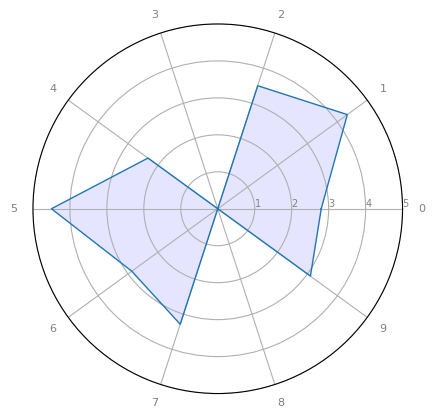

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# Set data
store = store.fillna(0)

'''
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
'''

# number of variable
categories = list(store)[0:]
N = len(categories)

# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values = store.values[0]
values = list(values)
values += values[:1]
values

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1,2,3,4,5], ["1","2","3","4","5"], color="grey", size=7)
plt.ylim(0,5)

# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')

# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

# Show the graph
plt.show()

In [84]:
store.values[0]

array([2.8       , 4.33333333, 3.5       , 0.        , 2.33333333,
       4.5       , 2.875     , 3.28571429, 0.        , 3.1       ])

In [85]:
values

[2.8,
 4.333333333333333,
 3.5,
 0.0,
 2.333333333333333,
 4.5,
 2.875,
 3.2857142857142856,
 0.0,
 3.1,
 2.8]